In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from pathlib import Path
import json
from glob import glob
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NSECS_IN_SEC = 1000000000

In [3]:
localization_df = pd.read_csv('YandexCup2024v2/YaCupTrain//0/localization.csv')
control_df = pd.read_csv('YandexCup2024v2/YaCupTrain/0/control_norm_v1.csv')

In [4]:
localization_df.head()

,stamp_ns,x,y,z,roll,pitch,yaw
0,0,-4292.313705,-14527.266319,66.043314,0.003926,-0.054198,-1.936810
1,39989868,-4292.489928,-14527.726083,66.070022,0.003702,-0.054172,-1.936858
2,79819886,-4292.662729,-14528.183063,66.090338,0.002404,-0.054628,-1.936827
3,125154671,-4292.862032,-14528.702952,66.120814,0.002709,-0.054559,-1.936894
4,159636974,-4293.011898,-14529.097871,66.138226,0.003264,-0.053668,-1.936876


In [5]:
control_df.head()

,stamp_ns,acceleration_level,steering,norm_acceleration_level,norm_steering
0,2987440736,-114,-2.655140,-0.451500,-0.061511
1,3027341070,-123,-2.598169,-0.510782,-0.060517
2,3066793076,-132,-2.544422,-0.570063,-0.059579
3,3106757146,-141,-2.544422,-0.629345,-0.059579
4,3146784622,-147,-2.488557,-0.668867,-0.058604


In [65]:
localization_df['stamp_ms'] = localization_df['stamp_ns'].astype(float) / NSECS_IN_SEC * 1000
control_df['stamp_ms'] = control_df['stamp_ns'].astype(float) / NSECS_IN_SEC * 1000
dx = (localization_df['x'].values[1:] - localization_df['x'].values[:-1])
localization_df['dx'] = np.concatenate([dx[:1], dx], axis=0)
dy = (localization_df['y'].values[1:] - localization_df['y'].values[:-1])
localization_df['dy'] = np.concatenate([dy[:1], dy], axis=0)


dt = (localization_df['stamp_ms'].values[1:] - localization_df['stamp_ms'].values[:-1])
localization_df['dt'] = np.concatenate([dt[:1], dt], axis=0)
localization_df['v_x'] = localization_df['dx'] / localization_df['dt']
localization_df['v_y'] = localization_df['dy'] / localization_df['dt']
localization_df['mod_v'] = (localization_df['v_x']**2 + localization_df['v_y']**2) ** (1/2)


dyaw = (localization_df['yaw'].values[1:] - localization_df['yaw'].values[:-1])
localization_df['dyaw'] = np.concatenate([[0], dyaw], axis=0)

localization_df['v_yaw'] = localization_df.dyaw / localization_df.dt

dv_x = (localization_df['v_x'].values[1:] - localization_df['v_x'].values[:-1])
localization_df['dv_x'] = np.concatenate([dv_x, [1e-9]], axis=0)
dv_y = (localization_df['v_y'].values[1:] - localization_df['v_y'].values[:-1])
localization_df['dv_y'] = np.concatenate([dv_y, [1e-9]], axis=0)

localization_df['a_x'] = localization_df['dv_y'] / localization_df['dt']
localization_df['a_y'] = localization_df['dv_y'] / localization_df['dt']
localization_df['mod_a'] = (localization_df['a_x']**2 + localization_df['a_y']**2) ** (1/2)



angle_mod = np.arctan2(np.abs(localization_df['dy'].values).tolist(), np.abs(localization_df['dx'].values).tolist())
direction = (localization_df['dx'].values < 0) # == (localization_df['dy'].values < 0)
angle_mod[direction] = np.pi - angle_mod[direction]
direction = (localization_df['dy'].values < 0)
angle_mod[direction] = - angle_mod[direction]
localization_df['v_angle'] = angle_mod

y2 = localization_df['y'].values[2:] - localization_df['y'].values[:-2]
x2 = localization_df['x'].values[2:] - localization_df['x'].values[:-2]
angle2_mod = np.arctan2(np.abs(y2), 
                        np.abs(x2)
                       )
direction = x2 < 0
angle2_mod[direction] = np.pi - angle2_mod[direction]
direction = y2 < 0
angle2_mod[direction] = - angle2_mod[direction]
localization_df['ac_angle'] = np.concatenate([angle2_mod[:1], angle2_mod, angle2_mod[-1:]], axis=0)


#localization_df['alpha'] = np.arctan(localization_df['y'].values / localization_df['x'].values[1:])

localization_df.head()

,stamp_ns,x,y,z,roll,pitch,yaw,stamp_ms,dx,dy,...,a_y,mod_a,v_angle,ac_angle,a_angle,d_yaw_a_angle,v_proj_yaw,d_yaw_v_angle,a_proj_yaw,v_yaw
0,0,-4292.313705,-14527.266319,66.043314,0.003926,-0.054198,-1.936810,0.000000,-0.176223,-0.459763,...,0.000000e+00,0.000000e+00,-1.936816,-1.934574,0.000000,-1.936810,0.012313,0.000007,-0.000000e+00,0.000000e+00
1,39989868,-4292.489928,-14527.726083,66.070022,0.003702,-0.054172,-1.936858,39.989868,-0.176223,-0.459763,...,5.935710e-07,8.394361e-07,-1.936816,-1.934574,0.334736,-2.271594,0.012313,-0.000041,-5.412914e-07,-1.202824e-06
2,79819886,-4292.662729,-14528.183063,66.090338,0.002404,-0.054628,-1.936827,79.819886,-0.172801,-0.456980,...,1.377020e-07,1.947401e-07,-1.932314,-1.934743,3.046986,-4.983813,0.012266,-0.004513,5.221049e-08,7.779530e-07
3,125154671,-4292.862032,-14528.702952,66.120814,0.002709,-0.054559,-1.936894,125.154671,-0.199303,-0.519889,...,3.304908e-07,4.673845e-07,-1.936874,-1.935415,0.290591,-2.227486,0.012282,-0.000020,-2.853374e-07,-1.493172e-06
4,159636974,-4293.011898,-14529.097871,66.138226,0.003264,-0.053668,-1.936876,159.636974,-0.149866,-0.394919,...,1.409101e-07,1.992770e-07,-1.933493,-1.935368,3.030633,-4.967509,0.012250,-0.003383,5.028979e-08,5.329548e-07


In [49]:
a_angle = np.arctan2(np.abs(localization_df['dv_y'].values).tolist(), np.abs(localization_df['dv_x'].values).tolist())
direction = (localization_df['dv_x'].values < 0)
a_angle[direction] = np.pi - a_angle[direction]
direction = (localization_df['dv_y'].values < 0)
a_angle[direction] = - a_angle[direction]
localization_df['a_angle'] = a_angle

alpha = localization_df['yaw'] - a_angle
localization_df['d_yaw_a_angle'] = alpha
cos_a = np.cos(alpha)
localization_df['a_proj_yaw'] = cos_a *localization_df['mod_a']

alpha = localization_df['yaw'] - localization_df['v_angle'].values
localization_df['d_yaw_v_angle'] = alpha
cos_v = np.cos(alpha)
localization_df['v_proj_yaw'] = cos_v * localization_df['mod_v']
#v_proj_yaw = cos_da * np.sqrt(localization_df['dv_y'][:, :, :2].pow(2).sum(dim=-1))
localization_df.head()

,stamp_ns,x,y,z,roll,pitch,yaw,stamp_ms,dx,dy,...,a_x,a_y,mod_a,v_angle,ac_angle,a_angle,d_yaw_a_angle,v_proj_yaw,d_yaw_v_angle,a_proj_yaw
0,0,-4292.313705,-14527.266319,66.043314,0.003926,-0.054198,-1.936810,0.000000,-0.176223,-0.459763,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.936816,-1.934574,0.000000,-1.936810,0.012313,0.000007,-0.000000e+00
1,39989868,-4292.489928,-14527.726083,66.070022,0.003702,-0.054172,-1.936858,39.989868,-0.176223,-0.459763,...,5.935710e-07,5.935710e-07,8.394361e-07,-1.936816,-1.934574,0.334736,-2.271594,0.012313,-0.000041,-5.412914e-07
2,79819886,-4292.662729,-14528.183063,66.090338,0.002404,-0.054628,-1.936827,79.819886,-0.172801,-0.456980,...,1.377020e-07,1.377020e-07,1.947401e-07,-1.932314,-1.934743,3.046986,-4.983813,0.012266,-0.004513,5.221049e-08
3,125154671,-4292.862032,-14528.702952,66.120814,0.002709,-0.054559,-1.936894,125.154671,-0.199303,-0.519889,...,3.304908e-07,3.304908e-07,4.673845e-07,-1.936874,-1.935415,0.290591,-2.227486,0.012282,-0.000020,-2.853374e-07
4,159636974,-4293.011898,-14529.097871,66.138226,0.003264,-0.053668,-1.936876,159.636974,-0.149866,-0.394919,...,1.409101e-07,1.409101e-07,1.992770e-07,-1.933493,-1.935368,3.030633,-4.967509,0.012250,-0.003383,5.028979e-08


In [29]:
localization_df['cos_yaw'] = np.cos(localization_df['yaw'])
localization_df['cos_angle'] = np.cos(localization_df['angle'])
localization_df['cos_angle2'] = np.cos(localization_df['angle2'])


localization_df['sin_yaw'] = np.sin(localization_df['yaw'])
localization_df['sin_angle'] = np.sin(localization_df['angle'])
localization_df['sin_angle2'] = np.sin(localization_df['angle2'])


localization_df[['yaw', 'angle', 'angle2', 'cos_yaw', 'cos_angle', 'cos_angle2', 'sin_yaw', 'sin_angle', 'sin_angle2']].head(10)

,yaw,angle,angle2,cos_yaw,cos_angle,cos_angle2,sin_yaw,sin_angle,sin_angle2
0,-1.936810,-1.936816,-1.934574,-0.357896,-0.357902,-0.355807,-0.933762,-0.933759,-0.934559
1,-1.936858,-1.936816,-1.934574,-0.357941,-0.357902,-0.355807,-0.933744,-0.933759,-0.934559
2,-1.936827,-1.932314,-1.934743,-0.357912,-0.353694,-0.355965,-0.933755,-0.935361,-0.934499
3,-1.936894,-1.936874,-1.935415,-0.357975,-0.357956,-0.356593,-0.933731,-0.933739,-0.934260
4,-1.936876,-1.933493,-1.935368,-0.357958,-0.354797,-0.356549,-0.933738,-0.934944,-0.934276
5,-1.936975,-1.936959,-1.936971,-0.358050,-0.358035,-0.358046,-0.933702,-0.933708,-0.933704
6,-1.937040,-1.936984,-1.936344,-0.358111,-0.358058,-0.357461,-0.933679,-0.933699,-0.933928
7,-1.937132,-1.935721,-1.936469,-0.358197,-0.356879,-0.357578,-0.933646,-0.934151,-0.933883
8,-1.937321,-1.937235,-1.934452,-0.358373,-0.358293,-0.355693,-0.933579,-0.933609,-0.934603
9,-1.937373,-1.931712,-1.934556,-0.358421,-0.353131,-0.355791,-0.933560,-0.935574,-0.934566


In [18]:
np.pow(localization_df.cos_yaw - localization_df.cos_angle, 2)[1:-1].sum()

np.float64(0.023367614369509054)

In [19]:
np.pow(localization_df.sin_yaw - localization_df.sin_angle, 2)[1:-1].sum()

np.float64(0.0029720777023307366)

In [20]:
np.pow(localization_df.cos_yaw - localization_df.cos_angle2, 2)[1:-1].sum()

np.float64(0.011615195317331078)

In [21]:
np.pow(localization_df.sin_yaw - localization_df.sin_angle2, 2)[1:-1].sum()

np.float64(0.0014978746131965545)

In [57]:
localization_df.head(10)

,stamp_ns,x,y,z,roll,pitch,yaw,stamp_ms,dx,dy,...,a_x,a_y,mod_a,v_angle,ac_angle,a_angle,d_yaw_a_angle,v_proj_yaw,d_yaw_v_angle,a_proj_yaw
0,0,-4292.313705,-14527.266319,66.043314,0.003926,-0.054198,-1.936810,0.000000,-0.176223,-0.459763,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.936816,-1.934574,0.000000,-1.936810,0.012313,0.000007,-0.000000e+00
1,39989868,-4292.489928,-14527.726083,66.070022,0.003702,-0.054172,-1.936858,39.989868,-0.176223,-0.459763,...,5.935710e-07,5.935710e-07,8.394361e-07,-1.936816,-1.934574,0.334736,-2.271594,0.012313,-0.000041,-5.412914e-07
2,79819886,-4292.662729,-14528.183063,66.090338,0.002404,-0.054628,-1.936827,79.819886,-0.172801,-0.456980,...,1.377020e-07,1.377020e-07,1.947401e-07,-1.932314,-1.934743,3.046986,-4.983813,0.012266,-0.004513,5.221049e-08
3,125154671,-4292.862032,-14528.702952,66.120814,0.002709,-0.054559,-1.936894,125.154671,-0.199303,-0.519889,...,3.304908e-07,3.304908e-07,4.673845e-07,-1.936874,-1.935415,0.290591,-2.227486,0.012282,-0.000020,-2.853374e-07
4,159636974,-4293.011898,-14529.097871,66.138226,0.003264,-0.053668,-1.936876,159.636974,-0.149866,-0.394919,...,1.409101e-07,1.409101e-07,1.992770e-07,-1.933493,-1.935368,3.030633,-4.967509,0.012250,-0.003383,5.028979e-08
5,200261036,-4293.190228,-14529.562932,66.165038,0.003789,-0.053473,-1.936975,200.261036,-0.178330,-0.465062,...,-8.904805e-07,-8.904805e-07,1.259330e-06,-1.936959,-1.936971,-1.944795,0.007820,0.012261,-0.000016,1.259291e-06
6,239886813,-4293.364739,-14530.017999,66.190968,0.004288,-0.053212,-1.937040,239.886813,-0.174511,-0.455067,...,-2.552794e-06,-2.552794e-06,3.610195e-06,-1.936984,-1.936344,-1.785089,-0.151951,0.012300,-0.000057,3.568597e-06
7,280229844,-4293.543296,-14530.485384,66.212334,0.005093,-0.053271,-1.937132,280.229844,-0.178557,-0.467385,...,2.696714e-06,2.696714e-06,3.813729e-06,-1.935721,-1.936469,1.374487,-3.311619,0.012402,-0.001411,-3.758736e-06
8,320020956,-4293.718550,-14530.942045,66.238342,0.006008,-0.053025,-1.937321,320.020956,-0.175254,-0.456662,...,-1.522401e-06,-1.522401e-06,2.153000e-06,-1.937235,-1.934452,-0.883691,-1.053630,0.012293,-0.000086,1.064484e-06
9,360304997,-4293.893972,-14531.406804,66.254371,0.005946,-0.052526,-1.937373,360.304997,-0.175423,-0.464759,...,1.924878e-06,1.924878e-06,2.722189e-06,-1.931712,-1.934556,2.108754,-4.046127,0.012331,-0.005661,-1.682454e-06


In [60]:
((localization_df.v_proj_yaw**2 - localization_df.mod_v**2)**2).max()

np.float64(1.860142539577892e-15)

In [53]:
control_df.head()

,stamp_ns,acceleration_level,steering,norm_acceleration_level,norm_steering,stamp_ms
0,2987440736,-114,-2.655140,-0.451500,-0.061511,2987.440736
1,3027341070,-123,-2.598169,-0.510782,-0.060517,3027.341070
2,3066793076,-132,-2.544422,-0.570063,-0.059579,3066.793076
3,3106757146,-141,-2.544422,-0.629345,-0.059579,3106.757146
4,3146784622,-147,-2.488557,-0.668867,-0.058604,3146.784622


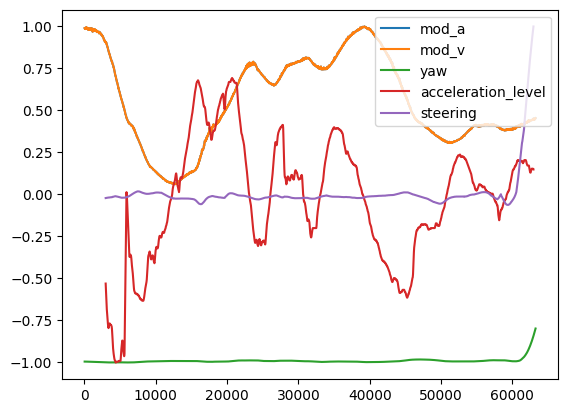

In [56]:
plt.plot(localization_df.stamp_ms.values[1:], localization_df.mod_v.values[1:]/np.abs(localization_df.mod_v.values[1:]).max())
plt.plot(localization_df.stamp_ms.values[1:], localization_df.v_proj_yaw.values[1:]/np.abs(localization_df.v_proj_yaw.values[1:]).max())

#plt.plot(localization_df.stamp_ms.values[1:], localization_df.v_proj_yaw.values[1:]/np.abs(localization_df.v_proj_yaw.values[1:]).max())
#plt.plot(localization_df.stamp_ms.values[1:], localization_df.mod_v.values[1:]/np.abs(localization_df.mod_v.values[1:]).max())
plt.plot(localization_df.stamp_ms.values[1:], localization_df.yaw[1:]/np.abs(localization_df.yaw.values[1:]).max())
plt.plot(control_df.stamp_ms.values, control_df.acceleration_level/np.abs(control_df.acceleration_level).max())
plt.plot(control_df.stamp_ms.values, control_df.steering/np.abs(control_df.steering).max())
plt.legend(['mod_a', 'mod_v', 'yaw', 'acceleration_level', 'steering'])

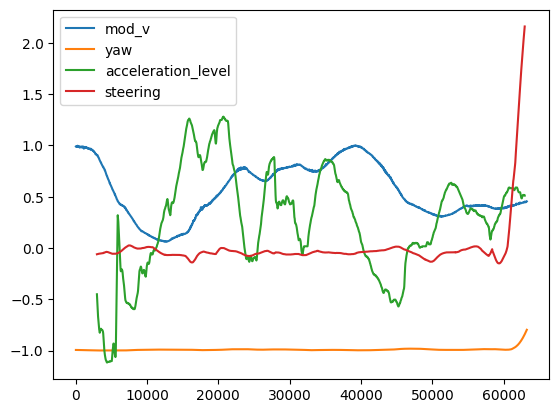

In [25]:
plt.plot(localization_df.stamp_ms.values[1:], localization_df.mod_v.values[1:]/np.abs(localization_df.mod_v.values[1:]).max())
plt.plot(localization_df.stamp_ms.values[1:], localization_df.yaw[1:]/np.abs(localization_df.yaw.values[1:]).max())
plt.plot(control_df.stamp_ms.values, control_df.norm_acceleration_level) #/np.abs(control_df.acceleration_level).max())
plt.plot(control_df.stamp_ms.values, control_df.norm_steering) #/np.abs(control_df.steering).max())
plt.legend(['mod_v', 'yaw', 'acceleration_level', 'steering'])

,stamp_ns,x,y,z,roll,pitch,yaw,stamp_ms,dx,dy,...,a_x,a_y,mod_a,v_angle,ac_angle,a_angle,d_yaw_a_angle,v_proj_yaw,d_yaw_v_angle,a_proj_yaw
100,4000534644,-4309.215687,-14570.621206,68.303842,0.011402,-0.049292,-1.947094,4000.534644,-0.141966,-0.359212,...,1.538556e-06,1.538556e-06,2.175847e-06,-1.947172,-1.947141,1.185682,-3.132776,0.009626,0.000078,-2.175762e-06
101,4040615759,-4309.356486,-14570.977528,68.322690,0.014035,-0.048928,-1.947073,4040.615759,-0.140799,-0.356322,...,3.484312e-06,3.484312e-06,4.927562e-06,-1.947111,-1.948696,1.409756,-3.356829,0.009559,0.000038,-4.813863e-06
102,4080353246,-4309.495177,-14571.325246,68.341144,0.014923,-0.048567,-1.947072,4080.353246,-0.138690,-0.347718,...,-5.103945e-08,-5.103945e-08,7.218069e-08,-1.950319,-1.948710,-0.063404,-1.883668,0.009421,0.003247,-2.221666e-08
103,4119752322,-4309.631427,-14571.670082,68.359001,0.017639,-0.047666,-1.947177,4119.752322,-0.136251,-0.344836,...,2.395217e-06,2.395217e-06,3.387348e-06,-1.947086,-1.946964,1.172351,-3.119529,0.009411,-0.000091,-3.386523e-06
104,4159637645,-4309.767775,-14572.015410,68.375599,0.014217,-0.046453,-1.946986,4159.637645,-0.136348,-0.345328,...,1.623442e-06,1.623442e-06,2.295893e-06,-1.946842,-1.946908,1.212118,-3.159103,0.009308,-0.000143,-2.295541e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,63079991016,-4445.953846,-14935.006202,66.762048,0.002899,-0.001396,-1.602179,63079.991016,-0.010492,-0.218176,...,-1.892223e-06,-1.892223e-06,2.676007e-06,-1.618847,-1.607369,-0.545681,-1.056497,0.005538,0.016668,1.316394e-06
1578,63120445325,-4445.959637,-14935.233032,66.762420,0.001984,-0.001401,-1.590317,63120.445325,-0.005791,-0.226830,...,8.040304e-07,8.040304e-07,1.137071e-06,-1.596320,-1.599791,2.437253,-4.027570,0.005609,0.006003,-7.192342e-07
1579,63160340945,-4445.966875,-14935.455432,66.758763,-0.000359,-0.001176,-1.578275,63160.340945,-0.007238,-0.222400,...,-1.086154e-06,-1.086154e-06,1.536053e-06,-1.603330,-1.587711,-0.245407,-1.332869,0.005576,0.025054,3.620312e-07
1580,63200463435,-4445.967213,-14935.680835,66.758973,0.000547,-0.000704,-1.565992,63200.463435,-0.000337,-0.225403,...,-7.782744e-07,-7.782744e-07,1.100646e-06,-1.572293,-1.566124,-0.420984,-1.145008,0.005618,0.006300,4.546094e-07


In [109]:
(pd.read_csv('YandexCup2024v2/YaCupTrain/0/control_norm_v1.csv')['stamp_ns'].astype(float) / NSECS_IN_SEC * 1000).max()

np.float64(62946.753648)

In [125]:
start = localization_df.iloc[0]
t=start.stamp_ms
x=start.x
y=start.y
yaw=start.yaw
pred = [(t, x, y, yaw)]
for i, row in localization_df.iloc[1:].iterrows():
    #v = row.v_proj_yaw
    v = row.mod_v
    v_yaw = row.v_yaw
    t, x, y, yaw = pred[-1]
    dt = row.stamp_ms - t
    new_yaw = yaw + v_yaw*dt
    new_x = x + v*dt * np.cos(row.v_angle)
    new_y = y + v*dt * np.sin(row.v_angle)
    pred.append((row.stamp_ms, new_x, new_y, new_yaw))

    
    
    
    
            
    

In [126]:
df_pred = pd.DataFrame(pred, columns=['stamp_ms', 'pred_x', 'pred_y', 'pred_yaw'])
#df_pred['stamp_ms'] = df_pred.stamp_ns.astype(int)
df_pred.head()

,stamp_ms,pred_x,pred_y,pred_yaw
0,0.000000,-4292.313705,-14527.266319,-1.936810
1,39.989868,-4292.489928,-14527.726083,-1.936858
2,79.819886,-4292.662729,-14528.183063,-1.936827
3,125.154671,-4292.862032,-14528.702952,-1.936894
4,159.636974,-4293.011898,-14529.097871,-1.936876


In [133]:
y2 = df_pred['pred_y'].values[2:] - df_pred['pred_y'].values[:-2]
x2 = df_pred['pred_x'].values[2:] - df_pred['pred_x'].values[:-2]
angle2_mod = np.arctan2(np.abs(y2), 
                        np.abs(x2)
                       )
direction = x2 < 0
angle2_mod[direction] = np.pi - angle2_mod[direction]
direction = y2 < 0
angle2_mod[direction] = - angle2_mod[direction]
df_pred['pred_yaw'][1:-1] = angle2_mod



/tmp/ipykernel_1488859/2119598668.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pred['pred_yaw'][1:-1] = angle2_mod


In [134]:
localization_df.head()

,stamp_ns,x,y,z,roll,pitch,yaw,stamp_ms,dx,dy,...,a_y,mod_a,v_angle,ac_angle,a_angle,d_yaw_a_angle,v_proj_yaw,d_yaw_v_angle,a_proj_yaw,v_yaw
0,0,-4292.313705,-14527.266319,66.043314,0.003926,-0.054198,-1.936810,0.000000,-0.176223,-0.459763,...,0.000000e+00,0.000000e+00,-1.936816,-1.934574,0.000000,-1.936810,0.012313,0.000007,-0.000000e+00,0.000000e+00
1,39989868,-4292.489928,-14527.726083,66.070022,0.003702,-0.054172,-1.936858,39.989868,-0.176223,-0.459763,...,5.935710e-07,8.394361e-07,-1.936816,-1.934574,0.334736,-2.271594,0.012313,-0.000041,-5.412914e-07,-1.202824e-06
2,79819886,-4292.662729,-14528.183063,66.090338,0.002404,-0.054628,-1.936827,79.819886,-0.172801,-0.456980,...,1.377020e-07,1.947401e-07,-1.932314,-1.934743,3.046986,-4.983813,0.012266,-0.004513,5.221049e-08,7.779530e-07
3,125154671,-4292.862032,-14528.702952,66.120814,0.002709,-0.054559,-1.936894,125.154671,-0.199303,-0.519889,...,3.304908e-07,4.673845e-07,-1.936874,-1.935415,0.290591,-2.227486,0.012282,-0.000020,-2.853374e-07,-1.493172e-06
4,159636974,-4293.011898,-14529.097871,66.138226,0.003264,-0.053668,-1.936876,159.636974,-0.149866,-0.394919,...,1.409101e-07,1.992770e-07,-1.933493,-1.935368,3.030633,-4.967509,0.012250,-0.003383,5.028979e-08,5.329548e-07


In [135]:
df_join = df_pred.set_index('stamp_ms').join(localization_df[['stamp_ms', 'x', 'y', 'yaw', 'v_proj_yaw', 'v_yaw']].set_index('stamp_ms'))
df_join.head()

,pred_x,pred_y,pred_yaw,x,y,yaw,v_proj_yaw,v_yaw
stamp_ms,,,,,,,,
0.000000,-4292.313705,-14527.266319,-1.936810,-4292.313705,-14527.266319,-1.936810,0.012313,0.000000e+00
39.989868,-4292.489928,-14527.726083,-1.934574,-4292.489928,-14527.726083,-1.936858,0.012313,-1.202824e-06
79.819886,-4292.662729,-14528.183063,-1.934743,-4292.662729,-14528.183063,-1.936827,0.012266,7.779530e-07
125.154671,-4292.862032,-14528.702952,-1.935415,-4292.862032,-14528.702952,-1.936894,0.012282,-1.493172e-06
159.636974,-4293.011898,-14529.097871,-1.935368,-4293.011898,-14529.097871,-1.936876,0.012250,5.329548e-07


In [136]:
df_join['mseX'] = ((df_join['pred_x'] - df_join.x)**2 + (df_join['pred_y'] - df_join.y)**2)**(1/2)
df_join['mse_yaw'] = ((np.cos(df_join.pred_yaw) - np.cos(df_join.yaw))**2 + (np.sin(df_join.pred_yaw) - np.sin(df_join.yaw))**2)**(1/2)
df_join['leaderbord'] = df_join.mseX+df_join.mse_yaw
df_join.head()

,pred_x,pred_y,pred_yaw,x,y,yaw,v_proj_yaw,v_yaw,mseX,mse_yaw,leaderbord
stamp_ms,,,,,,,,,,,
0.000000,-4292.313705,-14527.266319,-1.936810,-4292.313705,-14527.266319,-1.936810,0.012313,0.000000e+00,0.0,0.000000,0.000000
39.989868,-4292.489928,-14527.726083,-1.934574,-4292.489928,-14527.726083,-1.936858,0.012313,-1.202824e-06,0.0,0.002284,0.002284
79.819886,-4292.662729,-14528.183063,-1.934743,-4292.662729,-14528.183063,-1.936827,0.012266,7.779530e-07,0.0,0.002084,0.002084
125.154671,-4292.862032,-14528.702952,-1.935415,-4292.862032,-14528.702952,-1.936894,0.012282,-1.493172e-06,0.0,0.001479,0.001479
159.636974,-4293.011898,-14529.097871,-1.935368,-4293.011898,-14529.097871,-1.936876,0.012250,5.329548e-07,0.0,0.001508,0.001508


In [137]:
df_join['leaderbord'].mean()

np.float64(0.001918593347703666)